# Model Training and Evaluation

In [10]:
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

In [11]:
#Load data
df = pd.read_csv('data/features.csv')

# Create an empty DataFrame to store the model performance
model_control = pd.DataFrame(columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC-ROC'])

# Split the data into training and testing sets
X = df.drop('Exited', axis=1)
y = df['Exited']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define a list of classifiers to train
classifiers = [
    RandomForestClassifier(),
    LogisticRegression(),
    SVC(),
    KNeighborsClassifier(),
    GaussianNB()
]

# Train and evaluate each classifier
for classifier in classifiers:
    # Train the classifier
    classifier.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = classifier.predict(X_test)

    # Evaluate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred)

    # Print the evaluation results
    print(f"Classifier: {classifier.__class__.__name__}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-score: {f1:.4f}")
    print(f"AUC-ROC: {roc_auc:.4f}")

    # Plot the ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)
    print("-----------------------------------------")

    # Append the model performance to the model_control DataFrame
    row = pd.DataFrame([[classifier.__class__.__name__, accuracy, precision, recall, f1, roc_auc]],
                       columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC-ROC'])
    model_control = pd.concat([model_control, row], ignore_index=True)

# Save the model_control DataFrame to a CSV file
model_control.to_csv('models/model_control.csv', index=False)

Classifier: RandomForestClassifier
Accuracy: 0.8635
Precision: 0.7326
Recall: 0.4809
F1-score: 0.5806
AUC-ROC: 0.7190
-----------------------------------------
Classifier: LogisticRegression
Accuracy: 0.8145
Precision: 0.5764
Recall: 0.2112
F1-score: 0.3091
AUC-ROC: 0.5866
-----------------------------------------
Classifier: SVC
Accuracy: 0.8330
Precision: 0.9155
Recall: 0.1654
F1-score: 0.2802
AUC-ROC: 0.5808
-----------------------------------------
Classifier: KNeighborsClassifier
Accuracy: 0.8405
Precision: 0.6814
Recall: 0.3537
F1-score: 0.4657
AUC-ROC: 0.6566
-----------------------------------------
Classifier: GaussianNB
Accuracy: 0.8315
Precision: 0.6867
Recall: 0.2621
F1-score: 0.3794
AUC-ROC: 0.6164
-----------------------------------------


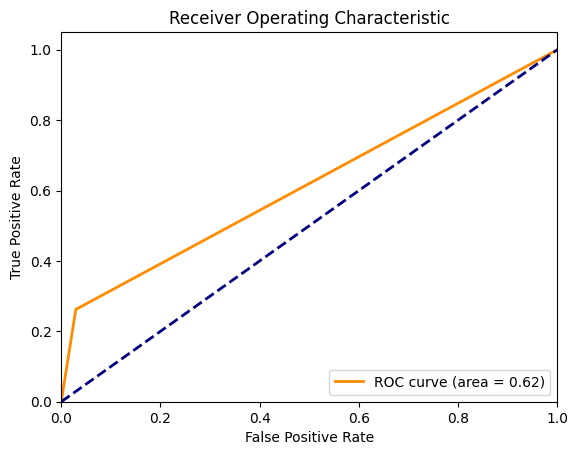

In [12]:
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()